In [1]:
# dataset_util.py

import os
import ujson
import numpy as np
import gc
from sklearn.model_selection import train_test_split

batch_size = 10
train_ratio = 0.75 # merge original training set and test set, then split it manually. 
alpha = 0.1 # for Dirichlet distribution

def check(config_path, train_path, test_path, num_clients, niid=False, 
        balance=True, partition=None):
    # check existing dataset
    if os.path.exists(config_path):
        with open(config_path, 'r') as f:
            config = ujson.load(f)
        if config['num_clients'] == num_clients and \
            config['non_iid'] == niid and \
            config['balance'] == balance and \
            config['partition'] == partition and \
            config['alpha'] == alpha and \
            config['batch_size'] == batch_size:
            print("\nDataset already generated.\n")
            return True

    dir_path = os.path.dirname(train_path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    dir_path = os.path.dirname(test_path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    return False

def separate_data(data, num_clients, num_classes, niid=False, balance=False, partition=None, class_per_client=None):
    X = [[] for _ in range(num_clients)]
    y = [[] for _ in range(num_clients)]
    statistic = [[] for _ in range(num_clients)]

    dataset_content, dataset_label = data
    # guarantee that each client must have at least one batch of data for testing. 
    least_samples = int(min(batch_size / (1-train_ratio), len(dataset_label) / num_clients / 2))

    dataidx_map = {}

    if not niid:
        partition = 'pat'
        class_per_client = num_classes

    if partition == 'pat':
        idxs = np.array(range(len(dataset_label)))
        idx_for_each_class = []
        for i in range(num_classes):
            idx_for_each_class.append(idxs[dataset_label == i])
       
        class_num_per_client = [class_per_client for _ in range(num_clients)]
        for i in range(num_classes):
            selected_clients = []
            for client in range(num_clients):
                if class_num_per_client[client] > 0:
                    selected_clients.append(client)
            selected_clients = selected_clients[:int(np.ceil((num_clients/num_classes)*class_per_client))]

            num_all_samples = len(idx_for_each_class[i])
            num_selected_clients = len(selected_clients)
            num_per = num_all_samples / num_selected_clients
            if balance:
                num_samples = [int(num_per) for _ in range(num_selected_clients-1)]
            else:
                num_samples = np.random.randint(max(num_per/10, least_samples/num_classes), num_per, num_selected_clients-1).tolist()
            num_samples.append(num_all_samples-sum(num_samples))

            idx = 0
            for client, num_sample in zip(selected_clients, num_samples):
                if client not in dataidx_map.keys():
                    dataidx_map[client] = idx_for_each_class[i][idx:idx+num_sample]
                else:
                    dataidx_map[client] = np.append(dataidx_map[client], idx_for_each_class[i][idx:idx+num_sample], axis=0)
                idx += num_sample
                class_num_per_client[client] -= 1

    elif partition == "dir":
        # https://github.com/IBM/probabilistic-federated-neural-matching/blob/master/experiment.py
        min_size = 0
        K = num_classes
        N = len(dataset_label)

        try_cnt = 1
        while min_size < least_samples:
            if try_cnt > 1:
                print(f'Client data size does not meet the minimum requirement {least_samples}. Try allocating again for the {try_cnt}-th time.')

            idx_batch = [[] for _ in range(num_clients)]
            for k in range(K):
                idx_k = np.where(dataset_label == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
                proportions = np.array([p*(len(idx_j)<N/num_clients) for p,idx_j in zip(proportions,idx_batch)])
                proportions = proportions/proportions.sum()
                proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
            try_cnt += 1

        for j in range(num_clients):
            dataidx_map[j] = idx_batch[j]
    else:
        raise NotImplementedError

    # assign data
    for client in range(num_clients):
        idxs = dataidx_map[client]
        X[client] = dataset_content[idxs]
        y[client] = dataset_label[idxs]

        for i in np.unique(y[client]):
            statistic[client].append((int(i), int(sum(y[client]==i))))
            

    del data
    # gc.collect()

    for client in range(num_clients):
        print(f"Client {client}\t Size of data: {len(X[client])}\t Labels: ", np.unique(y[client]))
        print(f"\t\t Samples of labels: ", [i for i in statistic[client]])
        print("-" * 50)

    return X, y, statistic

  
def split_data(X, y):
    # Split dataset
    train_data, test_data = [], []
    num_samples = {'train':[], 'test':[]}

    for i in range(len(y)):
        X_train, X_test, y_train, y_test = train_test_split(
            X[i], y[i], train_size=train_ratio, shuffle=True)

        train_data.append({'x': X_train, 'y': y_train})
        num_samples['train'].append(len(y_train))
        test_data.append({'x': X_test, 'y': y_test})
        num_samples['test'].append(len(y_test))

    print("Total number of samples:", sum(num_samples['train'] + num_samples['test']))
    print("The number of train samples:", num_samples['train'])
    print("The number of test samples:", num_samples['test'])
    print()
    del X, y
    # gc.collect()

    return train_data, test_data

def save_file(config_path, train_path, test_path, train_data, test_data, num_clients, 
                num_classes, statistic, niid=False, balance=True, partition=None):
    config = {
        'num_clients': num_clients, 
        'num_classes': num_classes, 
        'non_iid': niid, 
        'balance': balance, 
        'partition': partition, 
        'Size of samples for labels in clients': statistic, 
        'alpha': alpha, 
        'batch_size': batch_size, 
    }

    # gc.collect()
    print("Saving to disk.\n")

    for idx, train_dict in enumerate(train_data):
        with open(train_path + str(idx) + '.npz', 'wb') as f:
            np.savez_compressed(f, data=train_dict)
    for idx, test_dict in enumerate(test_data):
        with open(test_path + str(idx) + '.npz', 'wb') as f:
            np.savez_compressed(f, data=test_dict)
    with open(config_path, 'w') as f:
        ujson.dump(config, f)

    print("Finish generating dataset.\n")


In [2]:
# digit5

import numpy as np
import os
import random
import torchvision.transforms as transforms
import torch.utils.data as data
from os import path
from scipy.io import loadmat
from PIL import Image
from sklearn.utils import shuffle
from torch.utils.data import DataLoader

def dense_to_one_hot(labels_dense):
    """Convert class labels from scalars to one-hot vectors."""
    labels_one_hot = np.zeros((len(labels_dense),))
    labels_dense = list(labels_dense)
    for i, t in enumerate(labels_dense):
        if t == 10:
            t = 0
            labels_one_hot[i] = t
        else:
            labels_one_hot[i] = t
    return labels_one_hot


def load_mnist(base_path):
    print("load mnist")
    mnist_data = loadmat(path.join(base_path, "mnist_data.mat"))
    mnist_train = np.reshape(mnist_data['train_32'], (55000, 32, 32, 1))
    mnist_test = np.reshape(mnist_data['test_32'], (10000, 32, 32, 1))
    # turn to the 3 channel image with C*H*W
    mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
    mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)
    mnist_train = mnist_train.transpose(0, 3, 1, 2).astype(np.float32)
    mnist_test = mnist_test.transpose(0, 3, 1, 2).astype(np.float32)
    # get labels
    mnist_labels_train = mnist_data['label_train']
    mnist_labels_test = mnist_data['label_test']
    # random sample 25000 from train dataset and random sample 9000 from test dataset
    train_label = np.argmax(mnist_labels_train, axis=1)
    inds = np.random.permutation(mnist_train.shape[0])
    mnist_train = mnist_train[inds]
    train_label = train_label[inds]
    test_label = np.argmax(mnist_labels_test, axis=1)

    mnist_train = mnist_train[:25000]
    train_label = train_label[:25000]
    mnist_test = mnist_test[:9000]
    test_label = test_label[:9000]
    #print('mnist',mnist_train.shape,train_label.shape, mnist_test.shape,test_label.shape)
    return mnist_train, train_label, mnist_test, test_label


def load_mnist_m(base_path):
    print("load mnist_m")
    mnistm_data = loadmat(path.join(base_path, "mnistm_with_label.mat"))
    mnistm_train = mnistm_data['train']
    mnistm_test = mnistm_data['test']
    mnistm_train = mnistm_train.transpose(0, 3, 1, 2).astype(np.float32)
    mnistm_test = mnistm_test.transpose(0, 3, 1, 2).astype(np.float32)
    # get labels
    mnistm_labels_train = mnistm_data['label_train']
    mnistm_labels_test = mnistm_data['label_test']
    # random sample 25000 from train dataset and random sample 9000 from test dataset
    train_label = np.argmax(mnistm_labels_train, axis=1)
    inds = np.random.permutation(mnistm_train.shape[0])
    mnistm_train = mnistm_train[inds]
    train_label = train_label[inds]
    test_label = np.argmax(mnistm_labels_test, axis=1)
    mnistm_train = mnistm_train[:25000]
    train_label = train_label[:25000]
    mnistm_test = mnistm_test[:9000]
    test_label = test_label[:9000]
   # print('mnistm',mnistm_train.shape,train_label.shape, mnistm_test.shape,test_label.shape)
    return mnistm_train, train_label, mnistm_test, test_label


def load_svhn(base_path):
    print("load svhn")
    svhn_train_data = loadmat(path.join(base_path, "svhn_train_32x32.mat"))
    svhn_test_data = loadmat(path.join(base_path, "svhn_test_32x32.mat"))
    svhn_train = svhn_train_data['X']
    svhn_train = svhn_train.transpose(3, 2, 0, 1).astype(np.float32)
    svhn_test = svhn_test_data['X']
    svhn_test = svhn_test.transpose(3, 2, 0, 1).astype(np.float32)
    train_label = svhn_train_data["y"].reshape(-1)
    test_label = svhn_test_data["y"].reshape(-1)
    inds = np.random.permutation(svhn_train.shape[0])
    svhn_train = svhn_train[inds]
    train_label = train_label[inds]
    svhn_train = svhn_train[:25000]
    train_label = train_label[:25000]
    svhn_test = svhn_test[:9000]
    test_label = test_label[:9000]
    train_label[train_label == 10] = 0
    test_label[test_label == 10] = 0
    #print('svhn',svhn_train.shape,train_label.shape, svhn_test.shape,test_label.shape)
    return svhn_train, train_label, svhn_test, test_label


def load_syn(base_path):
    print("load syn")

    syn_data = loadmat(path.join(base_path, "syn_number.mat"))
    syn_train = syn_data['train_data']
    syn_test =  syn_data['test_data']
    syn_train = syn_train.transpose(0, 3, 1, 2).astype(np.float32)
    syn_test = syn_test.transpose(0, 3, 1, 2).astype(np.float32)
    syn_labels_train = syn_data['train_label']
    syn_labels_test = syn_data['test_label']

    train_label = syn_labels_train
    inds = np.random.permutation(syn_train.shape[0])
    syn_train = syn_train[inds]
    train_label = train_label[inds]
    test_label = syn_labels_test

    # syn_train = syn_train[:25000]
    # train_label = train_label[:25000]
    # syn_test = syn_test[:9000]
    # test_label = test_label[:9000]
    train_label = dense_to_one_hot(train_label)
    test_label = dense_to_one_hot(test_label)
    #print('syn',syn_train.shape,train_label.shape, syn_test.shape,test_label.shape)
    return syn_train, train_label, syn_test, test_label


def load_usps(base_path):
    print("load usps")
    usps_dataset = loadmat(path.join(base_path, "usps_28x28.mat"))
    usps_dataset = usps_dataset["dataset"]
    usps_train = usps_dataset[0][0]
    train_label = usps_dataset[0][1]
    train_label = train_label.reshape(-1)
    train_label[train_label == 10] = 0
    usps_test = usps_dataset[1][0]
    test_label = usps_dataset[1][1]
    test_label = test_label.reshape(-1)
    test_label[test_label == 10] = 0
    usps_train = usps_train * 255
    usps_test = usps_test * 255
    usps_train = np.concatenate([usps_train, usps_train, usps_train], 1)
   # print(usps_train.shape)
    usps_train = np.tile(usps_train, (4, 1, 1, 1))
    train_label = np.tile(train_label,4)
    usps_train = usps_train[:25000]
    train_label = train_label[:25000]
    usps_test = np.concatenate([usps_test, usps_test, usps_test], 1)
    #print('usps',usps_train.shape,train_label.shape, usps_test.shape,test_label.shape)
    return usps_train, train_label, usps_test, test_label

class Digit5Dataset(data.Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        super(Digit5Dataset, self).__init__()
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img, label = self.data[index], self.labels[index]
        if img.shape[0] != 1:
            # transpose to Image type,so that the transform function can be used
            img = Image.fromarray(np.uint8(np.asarray(img.transpose((1, 2, 0)))))

        elif img.shape[0] == 1:
            im = np.uint8(np.asarray(img))
            # turn the raw image into 3 channels
            im = np.vstack([im, im, im]).transpose((1, 2, 0))
            img = Image.fromarray(im)

        # do transform with PIL
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return self.data.shape[0]

def digit5_dataset_read(base_path, domain):
    if domain == "mnist":
        train_image, train_label, test_image, test_label = load_mnist(base_path)
    elif domain == "mnistm":
        train_image, train_label, test_image, test_label = load_mnist_m(base_path)
    elif domain == "svhn":
        train_image, train_label, test_image, test_label = load_svhn(base_path)
    elif domain == "syn":
        train_image, train_label, test_image, test_label = load_syn(base_path)
    elif domain == "usps":
        train_image, train_label, test_image, test_label = load_usps(base_path)
    else:
        raise NotImplementedError("Domain {} Not Implemented".format(domain))
    # define the transform function
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # raise train and test data loader
    train_dataset = Digit5Dataset(data=train_image, labels=train_label, transform=transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=False)
    test_dataset = Digit5Dataset(data=test_image, labels=test_label, transform=transform)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)
    return train_loader, test_loader



# Allocate data to usersz``
def generate_Digit5(dir_path, part_type='standard'):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
# 设置目录路径
    config_path = dir_path + "config.json"
    train_path = dir_path + "train/"
    test_path = dir_path + "test/"
    # config_path、train_path和test_path分别表示配置文件、训练数据和测试数据的存储路径。
    
# 创建目录 如果训练或测试数据的目录不存在，代码会创建这些目录。
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
# 初始化变量
    root = dir_path + "rawdata" 
    #`root`变量代表原始数据的路径。  
    X, y = [], []
    # `X`和`y`是空的列表，用于存储从各个数据源读取的图像和标签数据。  
    domains = ['mnistm', 'mnist', 'syn', 'usps', 'svhn']
    # `domains`是一个列表，包含要从中读取数据的各个数据源的名称。

# 读取数据
    for d in domains:
    # 对于domains列表中的每一个数据源d，代码使用digit5_dataset_read函数来读取训练和测试数据。
        train_loader, test_loader = digit5_dataset_read(root, d)
# 处理数据
        for _, tt in enumerate(train_loader):
        # 代码遍历`train_loader`和`test_loader`中的每一个数据批次。  
            train_data, train_label = tt
        for _, tt in enumerate(test_loader):
            test_data, test_label = tt

        dataset_image = []
        dataset_label = []
# 对于每个批次，它提取数据和标签，并将它们从PyTorch张量转换为NumPy数组。
# 这些图像和标签被分别添加到`dataset_image`和`dataset_label`列表中。  
        dataset_image.extend(train_data.cpu().detach().numpy())
        dataset_image.extend(test_data.cpu().detach().numpy())
        dataset_label.extend(train_label.cpu().detach().numpy())
        dataset_label.extend(test_label.cpu().detach().numpy())
# 最后，`dataset_image`和`dataset_label`被转换为NumPy数组，并分别添加到`X`和`y`列表中。
        X.append(np.array(dataset_image))
        y.append(np.array(dataset_label))
# 数据合并与随机打乱
    if part_type == 'shuffled':
        # Combine all datasets
        combined_X = np.concatenate(X)
        combined_y = np.concatenate(y)
        # Shuffle datasets 为了在后续的模型训练或评估中引入随机性，以减小数据顺序对结果的影响。
        combined_X, combined_y = shuffle(combined_X, combined_y, random_state=0)
        # 打乱后的数据集combined_X和combined_y会被分割成与数据源数量（len(domains)）相等的部分，每个部分代表一个数据源的数据。
        split_X = np.array_split(combined_X, len(domains))
        split_y = np.array_split(combined_y, len(domains))
        X = split_X
        y = split_y

# 代码计算每个数据源的标签种类数量（即每个数据源有多少种不同的标签）
# 并将这些数量存储在labelss列表中。同时，num_clients变量记录了数据源的数量，也就是客户端的数量。
    labelss = []
    for yy in y:
        labelss.append(len(set(yy)))
    num_clients = len(y)
    print(f'Number of labels: {labelss}')
    print(f'Number of clients: {num_clients}')
# 对于每个数据源（客户端），代码统计了每个标签出现的次数
# 并将结果以(label, count)的形式存储在statistic列表中。这有助于了解每个数据源的标签分布情况。
    statistic = [[] for _ in range(num_clients)]
    for client in range(num_clients):
        for i in np.unique(y[client]):
            statistic[client].append((int(i), int(sum(y[client] == i))))
# 使用split_data函数将合并后的数据集X和y分割成训练数据和测试数据。使用save_file函数将训练数据、
#测试数据、客户端数量、最大标签数量以及标签分布统计等信息保存到指定的配置路径、训练路径和测试路径中。
    train_data, test_data = split_data(X, y)
    save_file(config_path, train_path, test_path, train_data, test_data, num_clients, max(labelss), 
              statistic, None, None, None)


In [3]:
# model
import torch
import torch.nn.functional as F
from torch import nn

class FedAvgCNN(nn.Module):
    def __init__(self, in_features=1, num_classes=10, dim=1024):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features,
                        32,
                        kernel_size=5,
                        padding=0,
                        stride=1,
                        bias=True),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,
                        64,
                        kernel_size=5,
                        padding=0,
                        stride=1,
                        bias=True),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.fc1 = nn.Sequential(
            nn.Linear(dim, 512), 
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc(out)
        return out

class Digit5CNN(nn.Module):
    def __init__(self):
        super(Digit5CNN, self).__init__()
        self.encoder = nn.Sequential()
        self.encoder.add_module("conv1", nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2))
        self.encoder.add_module("bn1", nn.BatchNorm2d(64))
        self.encoder.add_module("relu1", nn.ReLU())
        self.encoder.add_module("maxpool1", nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False))
        self.encoder.add_module("conv2", nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2))
        self.encoder.add_module("bn2", nn.BatchNorm2d(64))
        self.encoder.add_module("relu2", nn.ReLU())
        self.encoder.add_module("maxpool2", nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False))
        self.encoder.add_module("conv3", nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2))
        self.encoder.add_module("bn3", nn.BatchNorm2d(128))
        self.encoder.add_module("relu3", nn.ReLU())

        self.linear = nn.Sequential()
        self.linear.add_module("fc1", nn.Linear(8192, 3072))
        self.linear.add_module("bn4", nn.BatchNorm1d(3072))
        self.linear.add_module("relu4", nn.ReLU())
        self.linear.add_module("dropout", nn.Dropout())
        self.linear.add_module("fc2", nn.Linear(3072, 2048))
        self.linear.add_module("bn5", nn.BatchNorm1d(2048))
        self.linear.add_module("relu5", nn.ReLU())

        self.fc = nn.Linear(2048, 10)

    def forward(self, x):
        batch_size = x.size(0)
        feature = self.encoder(x)
        feature = feature.view(batch_size, -1)
        feature = self.linear(feature)
        out = self.fc(feature)
        return out

In [4]:
# utils/data_utils.py
import numpy as np
import os
import torch



def read_data(dataset, idx, is_train=True):
    if is_train:
        train_data_dir = os.path.join('./dataset', dataset, 'train/')

        train_file = train_data_dir + str(idx) + '.npz'
        with open(train_file, 'rb') as f:
            train_data = np.load(f, allow_pickle=True)['data'].tolist()

        return train_data

    else:
        test_data_dir = os.path.join('./dataset', dataset, 'test/')

        test_file = test_data_dir + str(idx) + '.npz'
        with open(test_file, 'rb') as f:
            test_data = np.load(f, allow_pickle=True)['data'].tolist()

        return test_data


def read_client_data(dataset, idx, is_train=True):
    if "News" in dataset:
        return read_client_data_text(dataset, idx, is_train)
    elif "Shakespeare" in dataset:
        return read_client_data_Shakespeare(dataset, idx)

    if is_train:
        train_data = read_data(dataset, idx, is_train)
        X_train = torch.Tensor(train_data['x']).type(torch.float32)
        y_train = torch.Tensor(train_data['y']).type(torch.int64)

        train_data = [(x, y) for x, y in zip(X_train, y_train)]
        return train_data
    else:
        test_data = read_data(dataset, idx, is_train)
        X_test = torch.Tensor(test_data['x']).type(torch.float32)
        y_test = torch.Tensor(test_data['y']).type(torch.int64)
        test_data = [(x, y) for x, y in zip(X_test, y_test)]
        return test_data




In [5]:
# client base

import copy
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from sklearn import metrics


class Client(object):
    """
    Base class for clients in federated learning.
    """

    def __init__(self, args, id, train_samples, test_samples, **kwargs):
        torch.manual_seed(0)
        self.model = copy.deepcopy(args.model)
        self.algorithm = args.algorithm
        self.dataset = args.dataset
        self.device = args.device
        self.id = id  # integer
        self.save_folder_name = args.save_folder_name

        self.num_classes = args.num_classes
        self.train_samples = train_samples
        self.test_samples = test_samples
        self.batch_size = args.batch_size
        self.learning_rate = args.local_learning_rate
        self.local_epochs = args.local_epochs

        # check BatchNorm
        self.has_BatchNorm = False
        for layer in self.model.children():
            if isinstance(layer, nn.BatchNorm2d):
                self.has_BatchNorm = True
                break

        self.train_slow = kwargs['train_slow']
        self.send_slow = kwargs['send_slow']
        self.train_time_cost = {'num_rounds': 0, 'total_cost': 0.0}
        self.send_time_cost = {'num_rounds': 0, 'total_cost': 0.0}

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.learning_rate_scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer=self.optimizer, 
            gamma=args.learning_rate_decay_gamma
        )
        self.learning_rate_decay = args.learning_rate_decay


    def load_train_data(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        train_data = read_client_data(self.dataset, self.id, is_train=True)
        return DataLoader(train_data, batch_size, drop_last=True, shuffle=True)

    def load_test_data(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        test_data = read_client_data(self.dataset, self.id, is_train=False)
        return DataLoader(test_data, batch_size, drop_last=False, shuffle=True)
        
    def set_parameters(self, model):
        for new_param, old_param in zip(model.parameters(), self.model.parameters()):
            old_param.data = new_param.data.clone()

    def clone_model(self, model, target):
        for param, target_param in zip(model.parameters(), target.parameters()):
            target_param.data = param.data.clone()
            # target_param.grad = param.grad.clone()

    def update_parameters(self, model, new_params):
        for param, new_param in zip(model.parameters(), new_params):
            param.data = new_param.data.clone()

    def test_metrics(self):
        testloaderfull = self.load_test_data()
        self.model.eval()

        test_acc = 0
        test_num = 0
        y_prob = []
        y_true = []
        
        with torch.no_grad():
            for x, y in testloaderfull:
                if type(x) == type([]):
                    x[0] = x[0].to(self.device)
                else:
                    x = x.to(self.device)
                y = y.to(self.device)
                output = self.model(x)

                test_acc += (torch.sum(torch.argmax(output, dim=1) == y)).item()
                test_num += y.shape[0]

                y_prob.append(output.detach().cpu().numpy())
                nc = self.num_classes
                if self.num_classes == 2:
                    nc += 1
                lb = label_binarize(y.detach().cpu().numpy(), classes=np.arange(nc))
                if self.num_classes == 2:
                    lb = lb[:, :2]
                y_true.append(lb)


        y_prob = np.concatenate(y_prob, axis=0)
        y_true = np.concatenate(y_true, axis=0)

        auc = metrics.roc_auc_score(y_true, y_prob, average='micro')
        
        return test_acc, test_num, auc

    def train_metrics(self):
        trainloader = self.load_train_data()
        self.model.eval()

        train_num = 0
        losses = 0
        with torch.no_grad():
            for x, y in trainloader:
                if type(x) == type([]):
                    x[0] = x[0].to(self.device)
                else:
                    x = x.to(self.device)
                y = y.to(self.device)
                output = self.model(x)
                loss = self.loss(output, y)
                train_num += y.shape[0]
                losses += loss.item() * y.shape[0]


        return losses, train_num


    def save_item(self, item, item_name, item_path=None):
        if item_path == None:
            item_path = self.save_folder_name
        if not os.path.exists(item_path):
            os.makedirs(item_path)
        torch.save(item, os.path.join(item_path, "client_" + str(self.id) + "_" + item_name + ".pt"))

    def load_item(self, item_name, item_path=None):
        if item_path == None:
            item_path = self.save_folder_name
        return torch.load(os.path.join(item_path, "client_" + str(self.id) + "_" + item_name + ".pt"))


In [6]:
import torch
import os
import numpy as np
import h5py
import copy
import time
import random


class Server(object):
    def __init__(self, args, times):
        # Set up the main attributes
        self.args = args
        self.device = args.device
        self.dataset = args.dataset
        self.num_classes = args.num_classes
        self.global_rounds = args.global_rounds
        self.local_epochs = args.local_epochs
        self.batch_size = args.batch_size
        self.learning_rate = args.local_learning_rate
        self.global_model = copy.deepcopy(args.model)
        self.num_clients = args.num_clients
        self.join_ratio = args.join_ratio
        self.random_join_ratio = args.random_join_ratio
        self.num_join_clients = int(self.num_clients * self.join_ratio)
        self.current_num_join_clients = self.num_join_clients
        self.algorithm = args.algorithm
        self.time_select = args.time_select
        self.goal = args.goal
        self.time_threthold = args.time_threthold
        self.save_folder_name = args.save_folder_name
        self.top_cnt = 100

        self.clients = []
        self.selected_clients = []
        self.train_slow_clients = []
        self.send_slow_clients = []

        self.uploaded_weights = []
        self.uploaded_ids = []
        self.uploaded_models = []

        self.rs_test_acc = []
        self.rs_test_auc = []
        self.rs_train_loss = []

        self.times = times
        self.eval_gap = args.eval_gap
        self.client_drop_rate = args.client_drop_rate
        self.train_slow_rate = args.train_slow_rate
        self.send_slow_rate = args.send_slow_rate

        self.batch_num_per_client = args.batch_num_per_client

        self.num_new_clients = args.num_new_clients
        self.new_clients = []
        self.eval_new_clients = False
        self.fine_tuning_epoch_new = args.fine_tuning_epoch_new

    def set_clients(self, clientObj):
        for i, train_slow, send_slow in zip(range(self.num_clients), self.train_slow_clients, self.send_slow_clients):
            train_data = read_client_data(self.dataset, i, is_train=True)
            test_data = read_client_data(self.dataset, i, is_train=False)
            client = clientObj(self.args, 
                            id=i, 
                            train_samples=len(train_data), 
                            test_samples=len(test_data), 
                            train_slow=train_slow, 
                            send_slow=send_slow)
            self.clients.append(client)

    # random select slow clients
    def select_slow_clients(self, slow_rate):
        slow_clients = [False for i in range(self.num_clients)]
        idx = [i for i in range(self.num_clients)]
        idx_ = np.random.choice(idx, int(slow_rate * self.num_clients))
        for i in idx_:
            slow_clients[i] = True

        return slow_clients

    def set_slow_clients(self):
        self.train_slow_clients = self.select_slow_clients(
            self.train_slow_rate)
        self.send_slow_clients = self.select_slow_clients(
            self.send_slow_rate)

    def select_clients(self):
        if self.random_join_ratio:
            self.current_num_join_clients = np.random.choice(range(self.num_join_clients, self.num_clients+1), 1, replace=False)[0]
        else:
            self.current_num_join_clients = self.num_join_clients
        selected_clients = list(np.random.choice(self.clients, self.current_num_join_clients, replace=False))

        return selected_clients

    def send_models(self):
        assert (len(self.clients) > 0)

        for client in self.clients:
            start_time = time.time()
            
            client.set_parameters(self.global_model)

            client.send_time_cost['num_rounds'] += 1
            client.send_time_cost['total_cost'] += 2 * (time.time() - start_time)

    def receive_models(self):
        assert (len(self.selected_clients) > 0)

        active_clients = random.sample(
            self.selected_clients, int((1-self.client_drop_rate) * self.current_num_join_clients))

        self.uploaded_ids = []
        self.uploaded_weights = []
        self.uploaded_models = []
        tot_samples = 0
        for client in active_clients:
            try:
                client_time_cost = client.train_time_cost['total_cost'] / client.train_time_cost['num_rounds'] + \
                        client.send_time_cost['total_cost'] / client.send_time_cost['num_rounds']
            except ZeroDivisionError:
                client_time_cost = 0
            if client_time_cost <= self.time_threthold:
                tot_samples += client.train_samples
                self.uploaded_ids.append(client.id)
                self.uploaded_weights.append(client.train_samples)
                self.uploaded_models.append(client.model)
        for i, w in enumerate(self.uploaded_weights):
            self.uploaded_weights[i] = w / tot_samples

    def aggregate_parameters(self):
        assert (len(self.uploaded_models) > 0)

        self.global_model = copy.deepcopy(self.uploaded_models[0])
        for param in self.global_model.parameters():
            param.data.zero_()
            
        for w, client_model in zip(self.uploaded_weights, self.uploaded_models):
            self.add_parameters(w, client_model)

    def add_parameters(self, w, client_model):
        for server_param, client_param in zip(self.global_model.parameters(), client_model.parameters()):
            server_param.data += client_param.data.clone() * w

    def save_global_model(self):
        model_path = os.path.join("models", self.dataset)
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        model_path = os.path.join(model_path, self.algorithm + "_server" + ".pt")
        torch.save(self.global_model, model_path)

    def load_model(self):
        model_path = os.path.join("models", self.dataset)
        model_path = os.path.join(model_path, self.algorithm + "_server" + ".pt")
        assert (os.path.exists(model_path))
        self.global_model = torch.load(model_path)

    def model_exists(self):
        model_path = os.path.join("models", self.dataset)
        model_path = os.path.join(model_path, self.algorithm + "_server" + ".pt")
        return os.path.exists(model_path)
        
    def save_results(self):
        algo = self.dataset + "_" + self.algorithm
        result_path = "./results/"
        if not os.path.exists(result_path):
            os.makedirs(result_path)

        if (len(self.rs_test_acc)):
            algo = algo + "_" + self.goal + "_" + str(self.times)
            file_path = result_path + "{}.h5".format(algo)
            print("File path: " + file_path)

            with h5py.File(file_path, 'w') as hf:
                hf.create_dataset('rs_test_acc', data=self.rs_test_acc)
                hf.create_dataset('rs_test_auc', data=self.rs_test_auc)
                hf.create_dataset('rs_train_loss', data=self.rs_train_loss)

    def save_item(self, item, item_name):
        if not os.path.exists(self.save_folder_name):
            os.makedirs(self.save_folder_name)
        torch.save(item, os.path.join(self.save_folder_name, "server_" + item_name + ".pt"))

    def load_item(self, item_name):
        return torch.load(os.path.join(self.save_folder_name, "server_" + item_name + ".pt"))

    def test_metrics(self):
        if self.eval_new_clients and self.num_new_clients > 0:
            self.fine_tuning_new_clients()
            return self.test_metrics_new_clients()
        
        num_samples = []
        tot_correct = []
        tot_auc = []
        for c in self.clients:
            ct, ns, auc = c.test_metrics()
            tot_correct.append(ct*1.0)
            tot_auc.append(auc*ns)
            num_samples.append(ns)

        ids = [c.id for c in self.clients]

        return ids, num_samples, tot_correct, tot_auc

    def train_metrics(self):
        if self.eval_new_clients and self.num_new_clients > 0:
            return [0], [1], [0]
        
        num_samples = []
        losses = []
        for c in self.clients:
            cl, ns = c.train_metrics()
            num_samples.append(ns)
            losses.append(cl*1.0)

        ids = [c.id for c in self.clients]

        return ids, num_samples, losses

    # evaluate selected clients
    def evaluate(self, acc=None, loss=None):
        stats = self.test_metrics()
        stats_train = self.train_metrics()

        test_acc = sum(stats[2])*1.0 / sum(stats[1])
        test_auc = sum(stats[3])*1.0 / sum(stats[1])
        train_loss = sum(stats_train[2])*1.0 / sum(stats_train[1])
        accs = [a / n for a, n in zip(stats[2], stats[1])]
        aucs = [a / n for a, n in zip(stats[3], stats[1])]
        
        if acc == None:
            self.rs_test_acc.append(test_acc)
        else:
            acc.append(test_acc)
        
        if loss == None:
            self.rs_train_loss.append(train_loss)
        else:
            loss.append(train_loss)

        print("Averaged Train Loss: {:.4f}".format(train_loss))
        print("Averaged Test Accuracy: {:.4f}".format(test_acc))
        print("Averaged Test AUC: {:.4f}".format(test_auc))
        # self.print_(test_acc, train_acc, train_loss)
        print("Std Test Accuracy: {:.4f}".format(np.std(accs)))
        print("Std Test AUC: {:.4f}".format(np.std(aucs)))

    def print_(self, test_acc, test_auc, train_loss):
        print("Average Test Accuracy: {:.4f}".format(test_acc))
        print("Average Test AUC: {:.4f}".format(test_auc))
        print("Average Train Loss: {:.4f}".format(train_loss))

    def check_done(self, acc_lss, top_cnt=None, div_value=None):
        for acc_ls in acc_lss:
            if top_cnt != None and div_value != None:
                find_top = len(acc_ls) - torch.topk(torch.tensor(acc_ls), 1).indices[0] > top_cnt
                find_div = len(acc_ls) > 1 and np.std(acc_ls[-top_cnt:]) < div_value
                if find_top and find_div:
                    pass
                else:
                    return False
            elif top_cnt != None:
                find_top = len(acc_ls) - torch.topk(torch.tensor(acc_ls), 1).indices[0] > top_cnt
                if find_top:
                    pass
                else:
                    return False
            elif div_value != None:
                find_div = len(acc_ls) > 1 and np.std(acc_ls[-top_cnt:]) < div_value
                if find_div:
                    pass
                else:
                    return False
            else:
                raise NotImplementedError
        return True


    def set_new_clients(self, clientObj):
        for i in range(self.num_clients, self.num_clients + self.num_new_clients):
            train_data = read_client_data(self.dataset, i, is_train=True)
            test_data = read_client_data(self.dataset, i, is_train=False)
            client = clientObj(self.args, 
                            id=i, 
                            train_samples=len(train_data), 
                            test_samples=len(test_data), 
                            train_slow=False, 
                            send_slow=False)
            self.new_clients.append(client)

    # fine-tuning on new clients
    def fine_tuning_new_clients(self):
        for client in self.new_clients:
            client.set_parameters(self.global_model)
            opt = torch.optim.SGD(client.model.parameters(), lr=self.learning_rate)
            CEloss = torch.nn.CrossEntropyLoss()
            trainloader = client.load_train_data()
            client.model.train()
            for e in range(self.fine_tuning_epoch_new):
                for i, (x, y) in enumerate(trainloader):
                    if type(x) == type([]):
                        x[0] = x[0].to(client.device)
                    else:
                        x = x.to(client.device)
                    y = y.to(client.device)
                    output = client.model(x)
                    loss = CEloss(output, y)
                    opt.zero_grad()
                    loss.backward()
                    opt.step()

    # evaluating on new clients
    def test_metrics_new_clients(self):
        num_samples = []
        tot_correct = []
        tot_auc = []
        for c in self.new_clients:
            ct, ns, auc = c.test_metrics()
            tot_correct.append(ct*1.0)
            tot_auc.append(auc*ns)
            num_samples.append(ns)

        ids = [c.id for c in self.new_clients]

        return ids, num_samples, tot_correct, tot_auc


In [7]:
# fedavg
import copy
import torch
import numpy as np
import time


class clientAVG(Client):
    def __init__(self, args, id, train_samples, test_samples, **kwargs):
        super().__init__(args, id, train_samples, test_samples, **kwargs)

    def train(self):
        trainloader = self.load_train_data()
        # self.model.to(self.device)
        self.model.train()


        start_time = time.time()

        max_local_epochs = self.local_epochs
        if self.train_slow:
            max_local_epochs = np.random.randint(1, max_local_epochs // 2)

        for epoch in range(max_local_epochs):
            for i, (x, y) in enumerate(trainloader):
                if type(x) == type([]):
                    x[0] = x[0].to(self.device)
                else:
                    x = x.to(self.device)
                y = y.to(self.device)
                if self.train_slow:
                    time.sleep(0.1 * np.abs(np.random.rand()))
                output = self.model(x)
                loss = self.loss(output, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

        # self.model.cpu()

        if self.learning_rate_decay:
            self.learning_rate_scheduler.step()

        self.train_time_cost['num_rounds'] += 1
        self.train_time_cost['total_cost'] += time.time() - start_time


import time
from threading import Thread


class FedAvg(Server):
    def __init__(self, args, times):
        super().__init__(args, times)

        # select slow clients
        self.set_slow_clients()
        self.set_clients(clientAVG)

        print(f"\nJoin ratio / total clients: {self.join_ratio} / {self.num_clients}")
        print("Finished creating server and clients.")

        # self.load_model()
        self.Budget = []


    def train(self):
        for i in range(self.global_rounds+1):
            s_t = time.time()
            self.selected_clients = self.select_clients()
            self.send_models()

            if i%self.eval_gap == 0:
                print(f"\n-------------Round number: {i}-------------")
                print("\nEvaluate global model")
                self.evaluate()

            for client in self.selected_clients:
                client.train()

            # threads = [Thread(target=client.train)
            #            for client in self.selected_clients]
            # [t.start() for t in threads]
            # [t.join() for t in threads]

            self.receive_models()
 
            self.aggregate_parameters()

            self.Budget.append(time.time() - s_t)
            print('-'*25, 'time cost', '-'*25, self.Budget[-1])


        print("\nBest accuracy.")
        # self.print_(max(self.rs_test_acc), max(
        #     self.rs_train_acc), min(self.rs_train_loss))
        print(max(self.rs_test_acc))
        print("\nAverage time cost per round.")
        print(sum(self.Budget[1:])/len(self.Budget[1:]))

        self.save_results()
        self.save_global_model()

        if self.num_new_clients > 0:
            self.eval_new_clients = True
            self.set_new_clients(clientAVG)
            print(f"\n-------------Fine tuning round-------------")
            print("\nEvaluate new clients")
            self.evaluate()

In [8]:
# fedamp
import torch
import numpy as np
import time
import copy


class clientAMP(Client):
    def __init__(self, args, id, train_samples, test_samples, **kwargs):
        super().__init__(args, id, train_samples, test_samples, **kwargs)
        
        self.alphaK = args.alphaK
        self.lamda = args.lamda
        self.client_u = copy.deepcopy(self.model)

    def train(self):
        trainloader = self.load_train_data()
        start_time = time.time()

        # self.model.to(self.device)
        self.model.train()
        
        max_local_epochs = self.local_epochs
        if self.train_slow:
            max_local_epochs = np.random.randint(1, max_local_epochs // 2)

        for epoch in range(max_local_epochs):
            for x, y in trainloader:
                if type(x) == type([]):
                    x[0] = x[0].to(self.device)
                else:
                    x = x.to(self.device)
                y = y.to(self.device)
                if self.train_slow:
                    time.sleep(0.1 * np.abs(np.random.rand()))
                output = self.model(x)
                loss = self.loss(output, y)

                gm = torch.cat([p.data.view(-1) for p in self.model.parameters()], dim=0)
                pm = torch.cat([p.data.view(-1) for p in self.client_u.parameters()], dim=0)
                loss += 0.5 * self.lamda/self.alphaK * torch.norm(gm-pm, p=2)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

        # self.model.cpu()

        if self.learning_rate_decay:
            self.learning_rate_scheduler.step()

        self.train_time_cost['num_rounds'] += 1
        self.train_time_cost['total_cost'] += time.time() - start_time


    def set_parameters(self, model, coef_self):
        for new_param, old_param, self_param in zip(model.parameters(), self.client_u.parameters(), self.model.parameters()):
            old_param.data = (new_param.data + coef_self * self_param.data).clone()


    def train_metrics(self, model=None):
        trainloader = self.load_train_data()
        if model == None:
            model = self.model
        model.eval()

        train_num = 0
        losses = 0
        with torch.no_grad():
            for x, y in trainloader:
                if type(x) == type([]):
                    x[0] = x[0].to(self.device)
                else:
                    x = x.to(self.device)
                y = y.to(self.device)
                output = self.model(x)
                loss = self.loss(output, y)

                gm = torch.cat([p.data.view(-1) for p in self.model.parameters()], dim=0)
                pm = torch.cat([p.data.view(-1) for p in self.client_u.parameters()], dim=0)
                loss += 0.5 * self.lamda/self.alphaK * torch.norm(gm-pm, p=2)

                train_num += y.shape[0]
                losses += loss.item() * y.shape[0]

        return losses, train_num


import torch
import copy
import time
import numpy as np
import math
from threading import Thread

class FedAMP(Server):
    def __init__(self, args, times):
        super().__init__(args, times)

        # select slow clients
        self.set_slow_clients()
        self.set_clients(clientAMP)

        self.alphaK = args.alphaK
        self.sigma = args.sigma

        print(f"\nJoin ratio / total clients: {self.join_ratio} / {self.num_clients}")
        print("Finished creating server and clients.")
        self.Budget = []


    def train(self):
        for i in range(self.global_rounds+1):
            s_t = time.time()
            self.selected_clients = self.select_clients()
            self.send_models()

            if i%self.eval_gap == 0:
                print(f"\n-------------Round number: {i}-------------")
                print("\nEvaluate global model")
                self.evaluate()

            for client in self.selected_clients:
                client.train()


            self.receive_models()

            self.Budget.append(time.time() - s_t)
            print('-'*25, 'time cost', '-'*25, self.Budget[-1])

        print("\nBest accuracy.")
        print(max(self.rs_test_acc))
        print("\nAverage time cost per round.")
        print(sum(self.Budget[1:])/len(self.Budget[1:]))

        self.save_results()


    # To save GPU memory in simulation, no persistent model is kept on the server.
    def send_models(self):
        assert (len(self.selected_clients) > 0)

        if len(self.uploaded_ids) > 0:
            for c in self.selected_clients:
                mu = copy.deepcopy(self.global_model)
                for param in mu.parameters():
                    param.data.zero_()

                coef = torch.zeros(self.num_join_clients)
                for j, mw in enumerate(self.uploaded_models):
                    if c.id != self.uploaded_ids[j]:
                        weights_i = torch.cat([p.data.view(-1) for p in c.model.parameters()], dim=0)
                        weights_j = torch.cat([p.data.view(-1) for p in mw.parameters()], dim=0)
                        sub = (weights_i - weights_j).view(-1)
                        sub = torch.dot(sub, sub)
                        coef[j] = self.alphaK * self.e(sub)
                    else:
                        coef[j] = 0
                coef_self = 1 - torch.sum(coef)
                # print(i, coef)

                for j, mw in enumerate(self.uploaded_models):
                    for param, param_j in zip(mu.parameters(), mw.parameters()):
                        param.data += coef[j] * param_j

                start_time = time.time()

                if c.send_slow:
                    time.sleep(0.1 * np.abs(np.random.rand()))

                c.set_parameters(mu, coef_self)

                c.send_time_cost['num_rounds'] += 1
                c.send_time_cost['total_cost'] += 2 * (time.time() - start_time)

    def e(self, x):
        return math.exp(-x/self.sigma)/self.sigma



In [9]:
import copy
import torch
import argparse
import os
import time
import warnings
import numpy as np
import torchvision
import logging
import h5py
import numpy as np
import os


def average_data(algorithm="", dataset="", goal="", times=10):
    test_acc = get_all_results_for_one_algo(algorithm, dataset, goal, times)

    max_accuracy = []
    for i in range(times):
        max_accuracy.append(test_acc[i].max())

    print("std for best accuracy:", np.std(max_accuracy))
    print("mean for best accuracy:", np.mean(max_accuracy))


def get_all_results_for_one_algo(algorithm="", dataset="", goal="", times=10):
    test_acc = []
    algorithms_list = [algorithm] * times
    for i in range(times):
        file_name = dataset + "_" + algorithms_list[i] + "_" + goal + "_" + str(i)
        test_acc.append(np.array(read_data_then_delete(file_name, delete=False)))

    return test_acc


def read_data_then_delete(file_name, delete=False):
    file_path = "./results/" + file_name + ".h5"

    with h5py.File(file_path, 'r') as hf:
        rs_test_acc = np.array(hf.get('rs_test_acc'))

    if delete:
        os.remove(file_path)
    print("Length: ", len(rs_test_acc))

    return rs_test_acc



def run(args):

    time_list = []
    model_str = args.model

    for i in range(args.prev, args.times):
        print(f"\n============= Running time: {i}th =============")
        print("Creating server and clients ...")
        start = time.time()


        if model_str == "cnn": # non-convex
            if "mnist" in args.dataset:
                args.model = FedAvgCNN(in_features=1, num_classes=args.num_classes, dim=1024).to(args.device)
            elif "Cifar10" in args.dataset:
                args.model = FedAvgCNN(in_features=3, num_classes=args.num_classes, dim=1600).to(args.device)
            elif "Digit5" in args.dataset:
                args.model = Digit5CNN().to(args.device)

        print(args.model)

        # select algorithm
        if args.algorithm == "FedAvg":
            server = FedAvg(args, i)


        elif args.algorithm == "FedAMP":
            server = FedAMP(args, i)
          
        else:
            raise NotImplementedError

        server.train()

        time_list.append(time.time()-start)

    print(f"\nAverage time cost: {round(np.average(time_list), 2)}s.")
    

    # Global average
    average_data(dataset=args.dataset, algorithm=args.algorithm, goal=args.goal, times=args.times)

    print("All done!")

In [10]:
# dataset.py
random.seed(1)
np.random.seed(1)
num_clients = 20

dataset = "digit5"
#niid = True
#balance = True
# partition = "dir"
part_type = "shuffled"  # 为noniid/shuffled为iid

if dataset == "mnist":
    dir_path = "MNIST/"
    generate_mnist(dir_path, num_clients, niid, balance, partition)
elif dataset == "cifar10":
    dir_path = "Cifar10/"
    generate_cifar10(dir_path, num_clients, niid, balance, partition)
elif dataset == "digit5":
    dir_path = "./dataset/Digit5/"
    generate_Digit5(dir_path, part_type=part_type)
    

load mnist_m
load mnist
load syn
load usps
load svhn
Number of labels: [10, 10, 10, 10, 10]
Number of clients: 5
Total number of samples: 162860
The number of train samples: [24429, 24429, 24429, 24429, 24429]
The number of test samples: [8143, 8143, 8143, 8143, 8143]

Saving to disk.

Finish generating dataset.



In [12]:

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

warnings.simplefilter("ignore")
torch.manual_seed(0)

total_start = time.time()

conf = args_dict = {
    "goal": "noniid",# 有无差异
    "device": "cuda",
    "device_id": "0",
    "dataset": "Digit5", # 数据集
    "num_classes": 10,  
    "model": "cnn",  # 模型
    "batch_size": 10,  
    "local_learning_rate": 0.005,
    "learning_rate_decay": False,
    "learning_rate_decay_gamma": 0.99,
    "global_rounds": 50,  # 训练轮次
    "local_epochs": 1,
    "algorithm": "FedAvg",  # 算法 FedAvg/FedAMP
    "join_ratio": 1.0,
    "random_join_ratio": False,
    "num_clients": 5,  # 客户端数量
    "prev": 0,
    "times": 1,
    "eval_gap": 1,
    "save_folder_name": "items",
    "batch_num_per_client": 2,
    "num_new_clients": 0,
    "fine_tuning_epoch_new": 0,
    "client_drop_rate": 0.0,
    "train_slow_rate": 0.0,
    "send_slow_rate": 0.0,
    "time_select": False,
    "time_threthold": 10000,
    "beta": 0.0,
    "lamda": 1.0,
    "mu": 0.0,
    "K": 5,
    "p_learning_rate": 0.01,
    "alphaK": 1.0,
    "sigma": 1.0,
}


args = argparse.Namespace(**conf)


os.environ["CUDA_VISIBLE_DEVICES"] = args.device_id

if args.device == "cuda" and not torch.cuda.is_available():
    print("\ncuda is not avaiable.\n")
    args.device = "cpu"

print("=" * 50)

print("Algorithm: {}".format(args.algorithm))
print("Local batch size: {}".format(args.batch_size))
print("Local epochs: {}".format(args.local_epochs))
print("Local learing rate: {}".format(args.local_learning_rate))
print("Local learing rate decay: {}".format(args.learning_rate_decay))
if args.learning_rate_decay:
    print("Local learing rate decay gamma: {}".format(args.learning_rate_decay_gamma))
print("Total number of clients: {}".format(args.num_clients))
print("Clients join in each round: {}".format(args.join_ratio))
print("Clients randomly join: {}".format(args.random_join_ratio))
print("Client drop rate: {}".format(args.client_drop_rate))
print("Client select regarding time: {}".format(args.time_select))
if args.time_select:
    print("Time threthold: {}".format(args.time_threthold))
print("Running times: {}".format(args.times))
print("Dataset: {}".format(args.dataset))
print("Number of classes: {}".format(args.num_classes))
print("Backbone: {}".format(args.model))
print("Using device: {}".format(args.device))

if args.device == "cuda":
    print("Cuda device id: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))
print("Total number of new clients: {}".format(args.num_new_clients))
print("Fine tuning epoches on new clients: {}".format(args.fine_tuning_epoch_new))
print("=" * 50)
run(args)


cuda is not available. Falling back to CPU.

Algorithm: FedAvg
Local batch size: 10
Local epochs: 1
Local learing rate: 0.005
Local learing rate decay: False
Total number of clients: 5
Clients join in each round: 1.0
Clients randomly join: False
Client drop rate: 0.0
Client select regarding time: False
Running times: 1
Dataset: Digit5
Number of classes: 10
Backbone: cnn
Using device: cpu
Total number of new clients: 0
Fine tuning epoches on new clients: 0

============= Running time: 0th =============
Creating server and clients ...
Digit5CNN(
  (encoder): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

KeyboardInterrupt: 

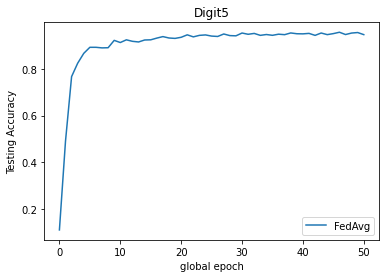

In [16]:
import matplotlib.pyplot as plt
import h5py
import numpy as np


def get_exp_data(filename):
    file_path = "./results/" + filename
    with h5py.File(file_path, 'r') as hf:
        rs_test_acc = np.array(hf.get('rs_test_acc'))
    return rs_test_acc


def plot_multi_compare(data_dict, save_fig=None, title="Acc Comparsion"):
    plt.figure()
    for k, v in data_dict.items():
        plt.plot(range(len(v)), v, label=k)
    plt.legend()
    plt.ylabel('Testing Accuracy')
    plt.xlabel("global epoch")
    plt.title(title)
    if save_fig:
        plt.savefig(os.path.join(save_fig))
    plt.show()
    plt.close()


data_dict = {
    "FedAvg": get_exp_data("Digit5_FedAvg_iid_0.h5")
}
plot_multi_compare(data_dict, title="Digit5")



In [ ]:
data_dict = {
    "FedAMP": get_exp_data("Digit5_FedAMP_iid_0"),
    "FedAvg": get_exp_data("Digit5_FedAvg_iid_0")
}

plot_multi_compare(data_dict, title="Digit5 on iid")

data_dict = {
    "FedAvg-iid": get_exp_data("Digit5_FedAvg_iid_0"),
    "FedAMP-noniid": get_exp_data("Digit5_FedAmp_noniid_0"),
    "FedAvg-noniid": get_exp_data("Digit5_FedAvg_noniid_0")
}

plot_multi_compare(data_dict, title="Digit5")
